# Experimento com uma nota fiscal

Este arquivo tem o objetivo de testar um modelo para extrair informações de uma Nota Fiscal e armazenar em um arquivo '.txt'.

## Importação

In [1]:
import pytesseract
import cv2
from matplotlib import pyplot as plt 
import numpy as np
import re
import json

import torch
from pytorch_pretrained_bert import BertTokenizer, BertForMaskedLM
from enchant.checker import SpellChecker # type: ignore
from typing import Tuple, List
import imutils
from pytesseract import Output

## Leitura de imagens

In [2]:
image_original = cv2.imread('../data/input/receipt.jpg', cv2.IMREAD_GRAYSCALE)

## Pré-processamento

In [3]:
# Transform grayscale image in binary image using an adaptive gaussian threshold
image_binary = cv2.adaptiveThreshold(image_original, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 33, 20)

# Get text orientation (angles) 
informations_obj = pytesseract.image_to_osd(image_binary, output_type=Output.DICT)

# Rotate the image to correct the orientation
image_rotated = imutils.rotate_bound(image_binary, angle=informations_obj['rotate'])

# Find image contours
contours = cv2.findContours(image_rotated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

# Fill a mask with the contour
mask = np.zeros(image_rotated.shape, dtype=np.uint8)
mask = cv2.fillPoly(mask, contours, [255,255,255])
mask = 255 - mask

# OR operation bitwise
bitwise = cv2.bitwise_or(image_rotated, mask)

image_preprocessed = bitwise

In [4]:
informations_obj

{'page_num': 0,
 'orientation': 0,
 'rotate': 0,
 'orientation_conf': 6.13,
 'script': 'Latin',
 'script_conf': 5.77}

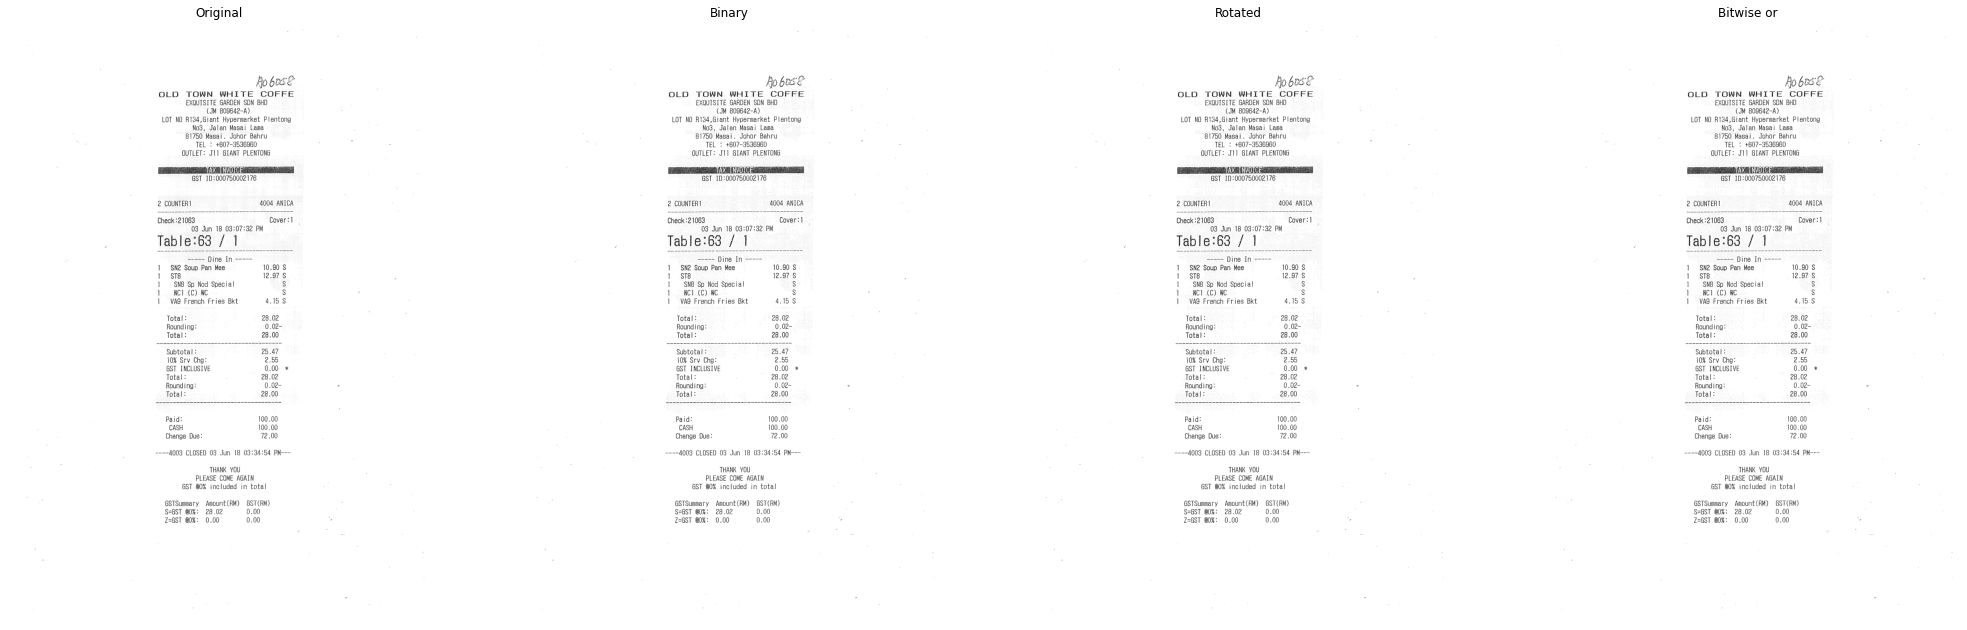

In [5]:
fig = plt.figure(figsize = (35,25))
fig.add_subplot(2,4,1)
plt.imshow(image_original, cmap="gray")
plt.title('Original')
plt.axis('off')

fig.add_subplot(2,4,2)
plt.imshow(image_binary, cmap="gray")
plt.title('Binary')
plt.axis('off')

fig.add_subplot(2,4,3)
plt.imshow(image_rotated, cmap="gray")
plt.title('Rotated')
plt.axis('off')

fig.add_subplot(2,4,4)
plt.imshow(bitwise, cmap="gray")
plt.title('Bitwise or')
plt.axis('off')

plt.show()

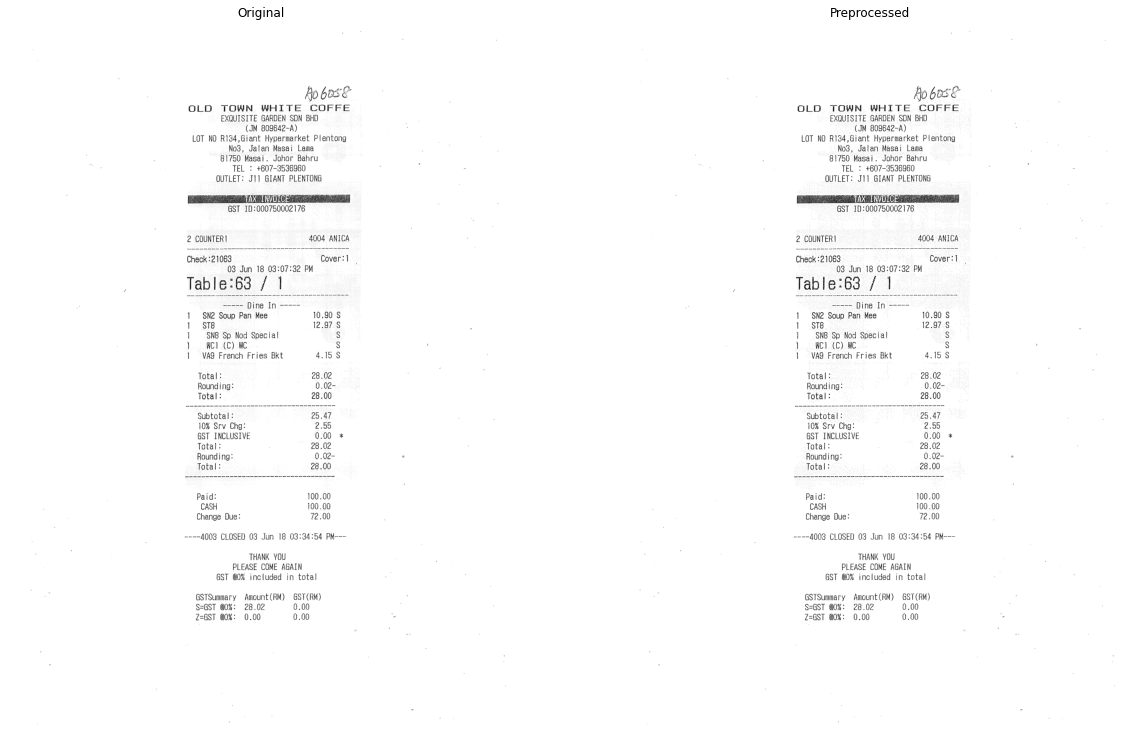

In [6]:
fig = plt.figure(figsize = (20,25))
fig.add_subplot(1,2,1)
plt.imshow(image_original, cmap="gray")
plt.title('Original')
plt.axis('off')

fig.add_subplot(1,2,2)
plt.imshow(image_preprocessed, cmap="gray")
plt.title('Preprocessed')
plt.axis('off')

plt.show()

## Extração de dados

In [7]:
text = pytesseract.image_to_string(image_preprocessed, lang='eng').upper()
print(text)

 

HO 685

OLD TOWN WHITE COFFE
| EXQUISITE GARDEN SON BHD A8
(JM 809642-A) — -
LOT NO RI 34, GIANT HYPERMARKET P FENTONG 8
 NO3, JALAN MASAI LAMA EEE
BI 750 HASAI. JOHOR BAHRU.”
TEL : +607-3536960 |

OUTLET: JI] GIANT PLENTONG

 

2 COUNTERT A 4004 M6 ANICA

CHECK: 21063. EUS COVER
“08 JUN 18 03:07: 32 PH 1 :

TABLE: 63 / |

S INE. GOO

| SN2 SOUP PAN HEE 10.90 $

1 ST8_ (12.97 § |

SNE SP NOD SPECIAL EESE

1 1 (C) WC. — §

“VIS FRENCH FRIES BKT 4.15 $
TOTAL: HEE WK 28.02
ROUNDING: OS OR
TOTAL: VE 28.00
SUBTOTAL: AP
10% SRV CHG: 2,85
GST INCLUSIVE 0.00 *
TOTAL: , 28 .02
ROUNDING: 0.02-
TOTAL: CED 28.00
“PAID: 100.00
CASH 100.00
CHANGE DUE: 72.00

~---A003 CLOSED 03 JUN 18 03:34:54 PK---

THANK YQU
PLEASE COME AGAIN
GST @O% INCLUDED IN TOTAL

GSTSUMMARY AMOUNTCRM) GSTCRM)
S=GST @0%: 28.02 0.00
Z7=GST @0%: 0.00 0.00



In [8]:
company = ""
address = ""
total = ""
date = ""

for row in text.split('\n'):
  if ('BHD' in row or 'RESTAURANT' in row or 'HARDWARE' in row or 'ENTERPRISE' in row or 'RESTORAN' in row or 'S/B' in row or 'PHARMACY' in row) and not company:
    company = row

  numerical_row = re.search('[\d][,|.]', row)
  if ('TOTAL' in row or 'RM' in row or 'DUE' in row or 'BUE' in row) and numerical_row and not total:
    total = row

  time_row = re.search('[\d][\d][\/|-][\w][\w][\w]*[\/|-][\d]*', row)
  if time_row:
      date = row

  time_row = re.search('[D][A|U][T][E]', row)
  if time_row and not date:
      date = row

  time_row = re.search('[\d][\d]\:[\d][\d]', row)
  if time_row and not date:
      date = row

if not company:
  company = text.strip().split('\n')[0]

end_address_string = 'TEL' if 'TEL' in text else 'TAX'
if end_address_string in text:
  if ')' in text:
    address = text[text.index(')')+len(')'):text.index(end_address_string)]
  if address == '' and company:
    address = text[text.index(company)+len(company):text.index(end_address_string)]
else:
  address = ''

if total:
  regex = re.search('[RM]*[ ]*[\\w]*([\\.|\\,]\\d\\d)', total)
  total = "" if regex is None else regex[0]
else:
  total = ""

print('company:', company)
print('address:', address)
print("total:", total)
print("date:", date)

company: | EXQUISITE GARDEN SON BHD A8
address:  — -
LOT NO RI 34, GIANT HYPERMARKET P FENTONG 8
 NO3, JALAN MASAI LAMA EEE
BI 750 HASAI. JOHOR BAHRU.”

total: 
date: “08 JUN 18 03:07: 32 PH 1 :


## Transformação de dados

In [9]:
def define_data_values(key, value):
  data_value = value.strip()
    
  if value:      
    if key == 'date':
      data_value = re.sub('[\d.]*[:][\d]*', '', data_value)
      data_value = re.sub('[Dd][Aa][Tt][Ee][:]*', '', data_value)
      if '/' in data_value or '-' in data_value:
        data_value = re.findall("[\d]*[\/-][\d]*[\/-]*[\d]*", data_value)[0]
    data_value = data_value.replace('PM', '').replace('AM', '').replace('\n',' ').strip()
    if key == 'total':
      data_value = data_value.replace(',', '.').replace(' ', '')

  return data_value

In [10]:
data = {}

data['company'] = define_data_values('company', company)
data['date'] = define_data_values('date', date)
data['address'] = define_data_values('address', address)
data['total'] = define_data_values('total', total)

output = json.dumps(data)
print(output)

{"company": "| EXQUISITE GARDEN SON BHD A8", "date": "\u201c08 JUN 18  32 PH 1", "address": "\u2014 - LOT NO RI 34, GIANT HYPERMARKET P FENTONG 8  NO3, JALAN MASAI LA EEE BI 750 HASAI. JOHOR BAHRU.\u201d", "total": ""}


## Armazenamento de dados

In [11]:
output_file = open('../data/output/'+'receipt_extracted.txt',"w+")
output_file.write(output)
output_file.close()